# Neural network for h->aa->bbtautau signal/background separation

# Model definition and training

## Packages

In [1]:
import ROOT
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Activation, Dense, Dropout
from keras.initializers import glorot_uniform
from keras.utils import plot_model

import kerastuner
from kerastuner import Hyperband

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

import joblib

Welcome to JupyROOT 6.22/06


Using TensorFlow backend.


## Load root files

In [2]:
file_obs18 = ROOT.RDataFrame('emu_tree', 'root_raw/em18_raw/data_obs.root')
file_sig18 = ROOT.RDataFrame('emu_tree', {'root_raw/em18_raw/ggH_bbtt*.root', 'root_raw/em18_raw/vbf_bbtt*.root'})
file_ZTT18 = ROOT.RDataFrame('emu_tree', 'root_raw/em18_raw/embedded.root')
file_TT18 = ROOT.RDataFrame('emu_tree', 'root_raw/em18_raw/TT*.root')

file_obs17 = ROOT.RDataFrame('emu_tree', 'root_raw/em17_raw/data_obs.root')
file_sig17 = ROOT.RDataFrame('emu_tree',  {'root_raw/em17_raw/ggH_bbtt*.root', 'root_raw/em17_raw/vbf_bbtt*.root'})
file_ZTT17 = ROOT.RDataFrame('emu_tree', 'root_raw/em17_raw/embedded.root')
file_TT17 = ROOT.RDataFrame('emu_tree', 'root_raw/em17_raw/TT*.root')

file_obs16 = ROOT.RDataFrame('emu_tree', 'root_raw/em16_raw/data_obs.root')
file_sig16 = ROOT.RDataFrame('emu_tree', {'root_raw/em16_raw/ggH_bbtt*.root', 'root_raw/em16_raw/vbf_bbtt*.root'})
file_ZTT16 = ROOT.RDataFrame('emu_tree', 'root_raw/em16_raw/embedded.root')
file_TT16 = ROOT.RDataFrame('emu_tree', 'root_raw/em16_raw/TT*.root')

files18 = [file_obs18, file_sig18, file_ZTT18, file_TT18]
files17 = [file_obs17, file_sig17, file_ZTT17, file_TT17]
files16 = [file_obs16, file_sig16, file_ZTT16, file_TT16]

In [3]:
# 1b events
for i in range(len(files18)):
    files18[i] = files18[i].Filter('bpt_deepflavour_1>20 && bscore_deepflavour_1>0.2770 && bpt_deepflavour_2<0')
    files17[i] = files17[i].Filter('bpt_deepflavour_1>20 && bscore_deepflavour_1>0.3033 && bpt_deepflavour_2<0')
    files16[i] = files16[i].Filter('bpt_deepflavour_1>20 && bscore_deepflavour_1>0.3093 && bpt_deepflavour_2<0')

## Define some input features

In [4]:
# define 4-vectors, invariant masses and etc.
myele = 'ROOT::Math::PtEtaPhiMVector(pt_1,eta_1,phi_1,m_1)'
mymu = 'ROOT::Math::PtEtaPhiMVector(pt_2,eta_2,phi_2,m_2)'
mymet = 'ROOT::Math::PtEtaPhiMVector(met,0,metphi,0)'
mytt = 'ROOT::Math::PtEtaPhiMVector((myele+mymu+mymet).Pt(),(myele+mymu+mymet).Eta(),(myele+mymu+mymet).Phi(),m_sv)'
myb1 = 'ROOT::Math::PtEtaPhiMVector(bpt_deepflavour_1,beta_deepflavour_1,bphi_deepflavour_1,bm_deepflavour_1)'
m_btt = '(mytt+myb1).M()'
m_b1ele = '(myele+myb1).M()'
m_b1mu = '(mymu+myb1).M()'
dR_tt = 'ROOT::Math::VectorUtil::DeltaR(myele,mymu)'
dR_b1ele = 'ROOT::Math::VectorUtil::DeltaR(myele,myb1)'
dR_b1mu = 'ROOT::Math::VectorUtil::DeltaR(mymu,myb1)'
dR_b1tt = 'ROOT::Math::VectorUtil::DeltaR(myb1,mytt)'
tt_pt = 'mytt.Pt()'
tt_eta = 'mytt.Eta()'

# define transverse masses mT and D_zeta
mT_ele = 'sqrt(pow(myele.Pt()+mymet.Pt(),2)-pow(myele.Px()+mymet.Px(),2)-pow(myele.Py()+mymet.Py(),2))'
mT_mu = 'sqrt(pow(mymu.Pt()+mymet.Pt(),2)-pow(mymu.Px()+mymet.Px(),2)-pow(mymu.Py()+mymet.Py(),2))'
mT_b1 = 'sqrt(pow(myb1.Pt()+mymet.Pt(),2)-pow(myb1.Px()+mymet.Px(),2)-pow(myb1.Py()+mymet.Py(),2))'
norm_zeta = 'sqrt(pow(myele.Px()/myele.Pt()+mymu.Px()/mymu.Pt(),2)+pow(myele.Py()/myele.Pt()+mymu.Py()/mymu.Pt(),2))'
x_zeta = '(myele.Px()/myele.Pt()+mymu.Px()/mymu.Pt())/norm_zeta'
y_zeta = '(myele.Py()/myele.Pt()+mymu.Py()/mymu.Pt())/norm_zeta'
p_zeta_mis = 'mymet.Px()*x_zeta+mymet.Py()*y_zeta'
pzeta_vis = '(myele.Px()+mymu.Px())*x_zeta+(myele.Py()+mymu.Py())*y_zeta'
Dzeta = 'p_zeta_mis-0.85*pzeta_vis'

# add defined variables to dataframe
for i in range(len(files18)):
    files18[i] = files18[i].Define('myele', myele)\
    .Define('mymu', mymu)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1mu', m_b1mu)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)
    
    files17[i] = files17[i].Define('myele', myele)\
    .Define('mymu', mymu)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1mu', m_b1mu)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)
    
    files16[i] = files16[i].Define('myele', myele)\
    .Define('mymu', mymu)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1mu', m_b1mu)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

## Apply baseline selection cuts

In [5]:
######################## 2 0 1 8 ##########################
# 2018 ele+mu trigger requirements
trigger823_18 = '(passMu8E23DZ && matchMu8E23DZ_1 && filterMu8E23DZ_1 && matchMu8E23DZ_2 && filterMu8E23DZ_2 && pt_1>24 && pt_2>13)'
trigger2312_18 = '(passMu23E12DZ && matchMu23E12DZ_1 && filterMu23E12DZ_1 && matchMu23E12DZ_2 && filterMu23E12DZ_2 && pt_1>13 && pt_2>24)'

trigger_all_18 = trigger823_18 + str(' or ') + trigger2312_18

for i in range(len(files18)):
    files18[i] = files18[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('Flag_ecalBadCalibReducedMINIAODFilter==0')\
    .Filter('fabs(eta_1)<2.4 && fabs(eta_2)<2.4')\
    .Filter('dR_tt>0.3')#fix

files18[0] = files18[0].Filter('Flag_eeBadScFilter==0')
files18[2] = files18[2].Filter('Flag_eeBadScFilter==0')

files18[3] = files18[3].Filter('!(gen_match_1>2 && gen_match_1<6 && gen_match_2>2 && gen_match_2<6)')

files18[1] = files18[1].Filter('gen_match_1==3 && gen_match_2==4')#reconstructed taus are gen taus
files18[1] = files18[1].Filter('m_btt<200')#reject long tail (mostly wrongly reco b jet)

# triggers
files18[0] = files18[0].Filter(trigger_all_18).Filter('iso_1<0.3 && iso_2<0.3')
files18[1] = files18[1].Filter(trigger_all_18).Filter('iso_1<0.15 && iso_2<0.15')
files18[2] = files18[2].Filter(trigger_all_18).Filter('iso_1<0.15 && iso_2<0.15')
files18[3] = files18[3].Filter(trigger_all_18).Filter('iso_1<0.15 && iso_2<0.15')

# QCD region
qcd_18 = files18[0].Filter('q_1*q_2>0').Filter('gen_match_1<6 && gen_match_2<6')

# signal region
for i in range(1,len(files18)):
    files18[i] = files18[i].Filter('q_1*q_2<0')

######################## 2 0 1 7 ##########################
# 2017 ele+mu trigger requirements 
trigger823_17 = '(passMu8E23DZ && matchMu8E23DZ_1 && filterMu8E23DZ_1 && matchMu8E23DZ_2 && filterMu8E23DZ_2 && pt_1>24 && pt_2>13)'
trigger2312_17 = '(passMu23E12DZ && matchMu23E12DZ_1 && filterMu23E12DZ_1 && matchMu23E12DZ_2 && filterMu23E12DZ_2 && pt_1>13 && pt_2>24)'

trigger_all_17 = trigger823_17 + str(' or ') + trigger2312_17

for i in range(len(files17)):
    files17[i] = files17[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('Flag_ecalBadCalibReducedMINIAODFilter==0')\
    .Filter('fabs(eta_1)<2.4 && fabs(eta_2)<2.4')\
    .Filter('dR_tt>0.3')#fix

files17[0] = files17[0].Filter('Flag_eeBadScFilter==0')
files17[2] = files17[2].Filter('Flag_eeBadScFilter==0')

files17[3] = files17[3].Filter('!(gen_match_1>2 && gen_match_1<6 && gen_match_2>2 && gen_match_2<6)')

files17[1] = files17[1].Filter('gen_match_1==3 && gen_match_2==4')#reconstructed taus are gen taus
files17[1] = files17[1].Filter('m_btt<200')#reject long tail (mostly wrongly reco b jet)

# triggers
files17[0] = files17[0].Filter(trigger_all_17).Filter('iso_1<0.3 && iso_2<0.3')
files17[1] = files17[1].Filter(trigger_all_17).Filter('iso_1<0.15 && iso_2<0.15')
files17[2] = files17[2].Filter(trigger_all_17).Filter('iso_1<0.15 && iso_2<0.15')
files17[3] = files17[3].Filter(trigger_all_17).Filter('iso_1<0.15 && iso_2<0.15')

# QCD region
qcd_17 = files17[0].Filter('q_1*q_2>0').Filter('gen_match_1<6 && gen_match_2<6')

# signal region
for i in range(1,len(files17)):
    files17[i] = files17[i].Filter('q_1*q_2<0')

######################## 2 0 1 6 ##########################
# 2016 ele+mu trigger requirements
trigger823_16 = '(passMu8E23 && matchMu8E23_1 && filterMu8E23_1 && matchMu8E23_2 && pt_1>24 && pt_2>13)'
trigger2312_16 = '(passMu23E12 && matchMu23E12_1 && filterMu23E12_1 && matchMu23E12_2 && pt_1>13 && pt_2>24)'

trigger_all_16 = trigger823_16 + str(' or ') + trigger2312_16

for i in range(len(files16)):
    files16[i] = files16[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('fabs(eta_1)<2.4 && fabs(eta_2)<2.4')\
    .Filter('dR_tt>0.3')#fix

files16[0] = files16[0].Filter('Flag_eeBadScFilter==0')
files16[2] = files16[2].Filter('Flag_eeBadScFilter==0')

files16[3] = files16[3].Filter('!(gen_match_1>2 && gen_match_1<6 && gen_match_2>2 && gen_match_2<6)')

files16[1] = files16[1].Filter('gen_match_1==3 && gen_match_2==4')#reconstructed taus are gen taus
files16[1] = files16[1].Filter('m_btt<200')#reject long tail (mostly wrongly reco b jet)

files16[2] = files16[2].Filter('genweight<=1.0')

# triggers
files16[0] = files16[0].Filter(trigger_all_16).Filter('iso_1<0.3 && iso_2<0.3')
files16[1] = files16[1].Filter(trigger_all_16).Filter('iso_1<0.15 && iso_2<0.15')
files16[2] = files16[2].Filter(trigger_all_16).Filter('iso_1<0.15 && iso_2<0.15')
files16[3] = files16[3].Filter(trigger_all_16).Filter('iso_1<0.15 && iso_2<0.15')

# QCD region
qcd_16 = files16[0].Filter('q_1*q_2>0').Filter('gen_match_1<6 && gen_match_2<6')

# signal region
for i in range(1,len(files16)):
    files16[i] = files16[i].Filter('q_1*q_2<0')

# [0]=obs, [1]=sig, [2]=embedded, [3]=ttbar

## Select all input features and save into pandas DataFrame

In [6]:
# list of feature variables
###### for 1b events
feature_list = ['pt_1', 'pt_2', 'm_btt', 'm_b1ele', 'm_b1mu',\
                'dR_tt', 'dR_b1ele', 'dR_b1mu', 'dR_b1tt',\
                'tt_pt', 'tt_eta', 'mT_ele', 'mT_mu', 'mT_b1', 'Dzeta',\
                'bpt_deepflavour_1']

# convert root RDataFrame into pandas DataFrame, saving only the features as columns
for i in range(1,len(files18)):
    files18[i] = pd.DataFrame(files18[i].AsNumpy(feature_list))
    files17[i] = pd.DataFrame(files17[i].AsNumpy(feature_list))
    files16[i] = pd.DataFrame(files16[i].AsNumpy(feature_list))
qcd_18 = pd.DataFrame(qcd_18.AsNumpy(feature_list))
qcd_17 = pd.DataFrame(qcd_17.AsNumpy(feature_list))
qcd_16 = pd.DataFrame(qcd_16.AsNumpy(feature_list))

print('sig18.shape  : ' + str(files18[1].shape))
print('ZTT18.shape  : ' + str(files18[2].shape))
print('TT18.shape   : ' + str(files18[3].shape))
print('qcd18.shape: ' + str(qcd_18.shape))
print('\nsig17.shape  : ' + str(files17[1].shape))
print('ZTT17.shape  : ' + str(files17[2].shape))
print('TT17.shape   : ' + str(files17[3].shape))
print('qcd17.shape  : ' + str(qcd_17.shape))
print('\nsig16.shape  : ' + str(files16[1].shape))
print('ZTT16.shape  : ' + str(files16[2].shape))
print('TT16.shape   : ' + str(files16[3].shape))
print('qcd16.shape  : ' + str(qcd_16.shape))

sig_allyears = [files18[1], files17[1], files16[1]]
ZTT_allyears = [files18[2], files17[2], files16[2]]
TT_allyears = [files18[3], files17[3], files16[3]]
qcd_allyears = [qcd_18, qcd_17, qcd_16]

sig_allyears = pd.concat(sig_allyears)
ZTT_allyears = pd.concat(ZTT_allyears)
TT_allyears = pd.concat(TT_allyears)
qcd_allyears = pd.concat(qcd_allyears)

# tag MC signal events as class 1
sig_allyears['label'] = np.ones((sig_allyears.shape[0], 1))

# tag MC background events as class 0
ZTT_allyears['label'] = np.zeros((ZTT_allyears.shape[0], 1))
TT_allyears['label'] = np.zeros((TT_allyears.shape[0],1))
qcd_allyears['label'] = np.zeros((qcd_allyears.shape[0], 1))

print('\nsig_allyears.shape: ' + str(sig_allyears.shape))
print('ZTT_allyears.shape: ' + str(ZTT_allyears.shape))
print('TT_allyears.shape : ' + str(TT_allyears.shape))
print('qcd_allyears.shape: ' + str(qcd_allyears.shape))

sig18.shape  : (39372, 16)
ZTT18.shape  : (266013, 16)
TT18.shape   : (2114820, 16)
qcd18.shape: (21712, 16)

sig17.shape  : (38344, 16)
ZTT17.shape  : (224249, 16)
TT17.shape   : (292604, 16)
qcd17.shape  : (14763, 16)

sig16.shape  : (32304, 16)
ZTT16.shape  : (105596, 16)
TT16.shape   : (2127967, 16)
qcd16.shape  : (6746, 16)

sig_allyears.shape: (110020, 17)
ZTT_allyears.shape: (595858, 17)
TT_allyears.shape : (4535391, 17)
qcd_allyears.shape: (43221, 17)


## Split into MC/data

In [7]:
# reduce class 0 sample size for balanced training
ZTT_allyears = ZTT_allyears.sample(n = 3411, random_state = 20)#3.1%
TT_allyears = TT_allyears.sample(n = 101768, random_state = 20)#92.5%
qcd_allyears = qcd_allyears.sample(n = 4841, random_state = 20)#4.4%

# collect all MC as one dataframe, separated from another datafream for observed data
df_bkg = [ZTT_allyears, TT_allyears, qcd_allyears]
df_bkg = pd.concat(df_bkg)

df_MC = [sig_allyears, ZTT_allyears, TT_allyears, qcd_allyears]
df_MC = pd.concat(df_MC)

#print('\nObserved dataframe: \n' + str(df_obs))
print('\nMC dataframe: \n' + str(df_MC))


MC dataframe: 
             pt_1       pt_2        m_btt     m_b1ele      m_b1mu     dR_tt  \
0       18.506472  35.840324    67.989100   50.800191   65.320352  0.416608   
1       30.498535  18.967522   127.285525   92.897294   82.123609  0.377537   
2       13.985417  28.660513   101.936764   46.715899   67.591968  0.426489   
3       17.544931  29.919268   139.819715   62.026384   80.839403  0.319008   
4       28.667122  14.706291   122.091292   89.902190   62.594955  0.344064   
...           ...        ...          ...         ...         ...       ...   
19590   21.706903  38.567867   407.632953  253.191832   72.450523  3.768362   
1408   126.739433  16.878841  1377.489891  227.903770   81.036388  3.040919   
4437    44.616978  72.256531   621.999934  418.498426  324.768006  2.290808   
2330    20.593904  38.994297   223.708702   90.134035  108.044261  1.826350   
11160   35.299683  18.868513   215.865451   44.834424   81.955448  1.812873   

       dR_b1ele   dR_b1mu   dR_b1tt

## Compare input feature distributions between sig and bkg

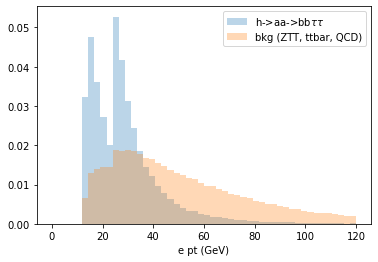

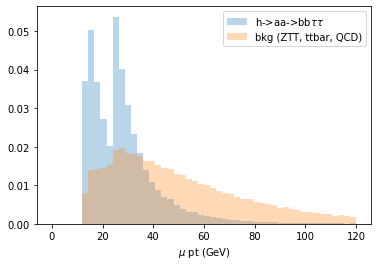

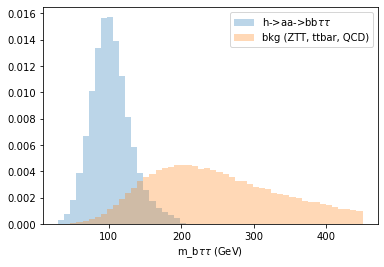

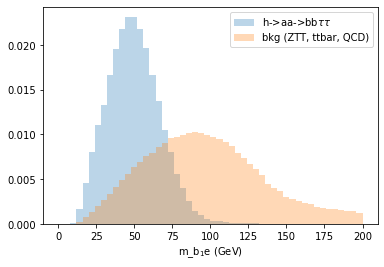

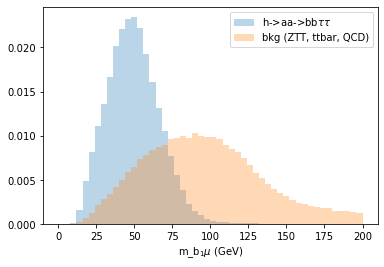

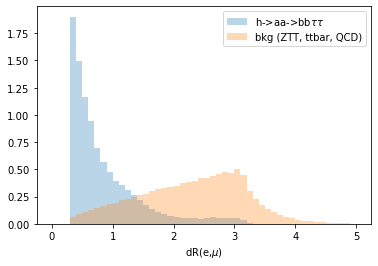

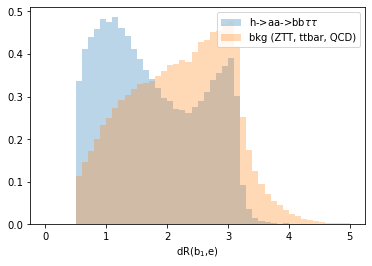

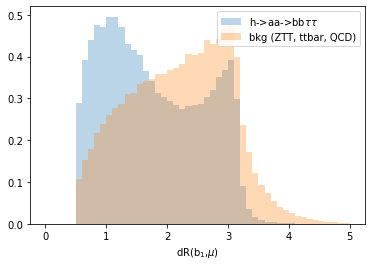

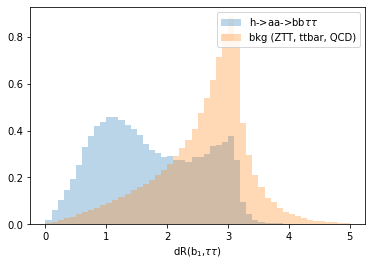

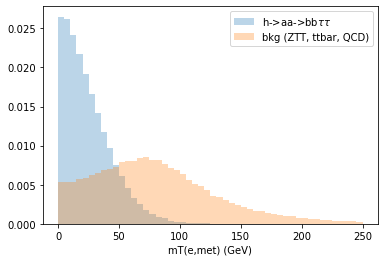

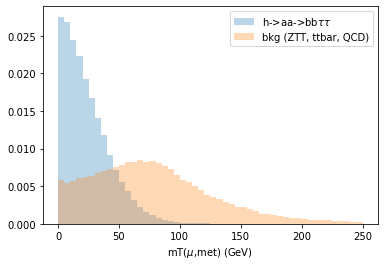

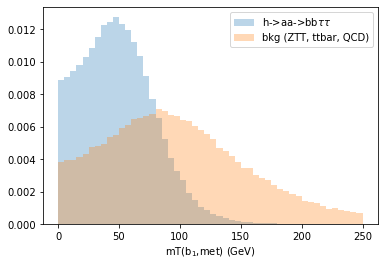

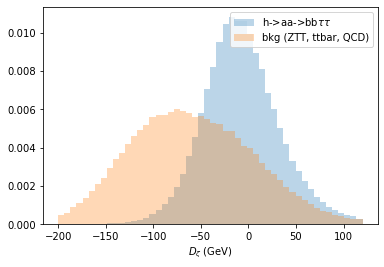

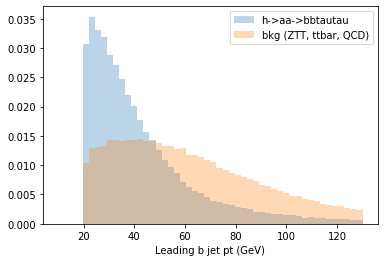

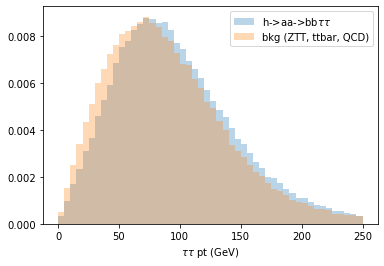

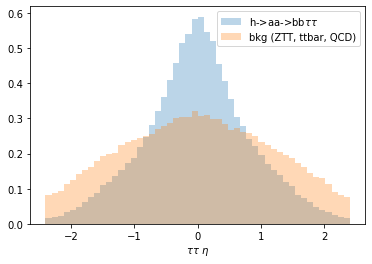

In [8]:
pyplot.hist(sig_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('e pt (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['pt_2'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['pt_2'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['pt_2'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['pt_2'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['pt_2'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\mu$ pt (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$\\tau\\tau$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b1ele'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b1ele'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['m_b1ele'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['m_b1ele'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['m_b1ele'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_1$e (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_1$$\mu$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(e,$\mu$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b1ele'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b1ele'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_b1ele'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_b1ele'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_b1ele'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,e)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\mu$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\\tau\\tau$)')
pyplot.show()

pyplot.hist(sig_allyears['mT_ele'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_ele'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['mT_ele'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['mT_ele'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['mT_ele'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT(e,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT($\mu$,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT(b$_1$,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$D_\zeta$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['bpt_deepflavour_1'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(df_bkg['bpt_deepflavour_1'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['bpt_deepflavour_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['bpt_deepflavour_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['bpt_deepflavour_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('Leading b jet pt (GeV)')
pyplot.show()


pyplot.hist(sig_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\\tau\\tau$ pt (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\\tau\\tau$ $\eta$')
pyplot.show()


## Input data pre-processing

In [9]:
# convert to numpy arrays
dataset = df_MC.values
X = dataset[:,0:(dataset.shape[1]-1)]
Y = dataset[:,dataset.shape[1]-1]
Y = Y.reshape(Y.shape[0],1)

#dataset_obs = df_obs.values
#X_obs = dataset_obs[:,0:(dataset_obs.shape[1])]

# give train/val/test partition ratios
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 1 - train_ratio - val_ratio

# randomly partition data set into train/val/test sets with given ratios
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size = test_ratio, random_state=15)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = val_ratio/(val_ratio+train_ratio), random_state=15)

# standardize feature variables
# only based on means and stds in train_val set, should apply this only scaler to all other sets
# think of the transformation in phase space
scaler = StandardScaler().fit(X_train_val)
X_train_val = scaler.transform(X_train_val)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
#X_obs = scaler.transform(X_obs)

# print input data shapes
print("\nPartition the data set into train/val/test: %.2f/%.2f/%.2f" % (train_ratio, val_ratio, test_ratio))
print("X_train.shape: " + str(X_train.shape))
print("Y_train.shape: " + str(Y_train.shape))
print("X_val.shape: " + str(X_val.shape))
print("Y_val.shape: " + str(Y_val.shape))
print("X_test.shape: " + str(X_test.shape))
print("Y_test.shape: " + str(Y_test.shape))
#print("\nX_obs.shape: " + str(X_obs.shape))

# print ratio of signal/background examples in each set
train_sig = np.count_nonzero(Y_train)
train_bkg = np.count_nonzero(Y_train == 0)
train_sig_perc = 100*train_sig/(train_sig+train_bkg)
train_bkg_perc = 100*train_bkg/(train_sig+train_bkg)
val_sig = np.count_nonzero(Y_val)
val_bkg = np.count_nonzero(Y_val == 0)
val_sig_perc = 100*val_sig/(val_sig+val_bkg)
val_bkg_perc = 100*val_bkg/(val_sig+val_bkg)
test_sig = np.count_nonzero(Y_test)
test_bkg = np.count_nonzero(Y_test == 0)
test_sig_perc = 100*test_sig/(test_sig+test_bkg)
test_bkg_perc = 100*test_bkg/(test_sig+test_bkg)

total_sig = train_sig + val_sig + test_sig
total_bkg = train_bkg + val_bkg + test_bkg
total_sig_perc = 100*total_sig/(total_sig+total_bkg)
total_bkg_perc = 100*total_bkg/(total_sig+total_bkg)
print("\nTotal number of sig/bkg examples: %d/%d (%.2f%%/%.2f%%)" % (total_sig, total_bkg, total_sig_perc, total_bkg_perc))

print("\nNumber of sig/bkg examples in each set:")
print("train : %d/%d (%.1f%%/%.1f%%)" % (train_sig, train_bkg, train_sig_perc, train_bkg_perc))
print("val   : %d/%d (%.1f%%/%.1f%%)" % (val_sig, val_bkg, val_sig_perc, val_bkg_perc))
print("test  : %d/%d (%.1f%%/%.1f%%)" % (test_sig, test_bkg, test_sig_perc, test_bkg_perc))


Partition the data set into train/val/test: 0.60/0.20/0.20
X_train.shape: (132024, 16)
Y_train.shape: (132024, 1)
X_val.shape: (44008, 16)
Y_val.shape: (44008, 1)
X_test.shape: (44008, 16)
Y_test.shape: (44008, 1)

Total number of sig/bkg examples: 110020/110020 (50.00%/50.00%)

Number of sig/bkg examples in each set:
train : 65969/66055 (50.0%/50.0%)
val   : 21938/22070 (49.9%/50.1%)
test  : 22113/21895 (50.2%/49.8%)


## DNN Hyperparameters searching

In [ ]:
# define model for the search
def hypermodel(hp):
    hp_model = keras.Sequential()
    hp_model.add(keras.layers.Input(shape = (X.shape[1],)))
    
    hp_model.add(keras.layers.Dense(units = hp.Int('units_1',
                                                   min_value = 20,
                                                   max_value = 60,
                                                   step = 2),
                                    activation = 'relu',
                                    kernel_initializer = glorot_uniform(seed=1)))
    
    hp_model.add(keras.layers.Dropout(rate = hp.Float('rate_1',
                                                      min_value = 0.2,
                                                      max_value = 0.5,
                                                      default = 0.2,
                                                      step = 0.1),
                                      seed = 10))
    
    hp_model.add(keras.layers.Dense(units = hp.Int('units_2',
                                                   min_value = 20,
                                                   max_value = 60,
                                                   step = 2),
                                    activation = 'relu',
                                    kernel_initializer = glorot_uniform(seed=1)))
    
    hp_model.add(keras.layers.Dropout(rate = hp.Float('rate_2',
                                                      min_value = 0.2,
                                                      max_value = 0.5,
                                                      default = 0.2,
                                                      step = 0.1),
                                      seed = 10))

    hp_model.add(keras.layers.Dense(units = 1, activation = 'sigmoid', kernel_initializer = glorot_uniform(seed=1)))
    hp_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return hp_model

In [ ]:
# define tuner model
tuner = Hyperband(hypermodel,
                  objective = 'val_accuracy',
                  max_epochs = 20,
                  factor = 3, #number of models to train in a bracket = 1+log_factor(max_epochs)
                  hyperband_iterations = 2, #number of times to iterate over the full Hyperband algorithm
                  seed = 10,
                  directory = 'hypertuning',
                  project_name = 'tune',
                  overwrite = True)

In [ ]:
# run the search
tuner.search(X_train, Y_train, epochs = 20, validation_data = (X_val,Y_val), batch_size = 256)

In [ ]:
tuner.results_summary()

## Model topology

In [10]:
######## input layer ########
X_input = Input(shape = (X.shape[1],), name = 'X_input')

######## hidden layers ########
hidden_1 = Dense(
    units = 52,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_1'
)(X_input)

dropout_1 = Dropout(rate = 0.4, seed = 10, name = 'Dropout_layer_1')(hidden_1)

hidden_2 = Dense(
    units = 34,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_2'
)(dropout_1)

dropout_2 = Dropout(rate = 0.3, seed = 10, name = 'Dropout_layer_2')(hidden_2)

######## output layer #######
Y_output = Dense(
    units = 1,
    activation = 'sigmoid',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Y_output'
)(dropout_2)


model = Model(inputs = X_input, outputs = Y_output)

# use adaptive moment estimation (adam) to train, which uses both GD with momentum and RMSprop
# the default hyperparameters in adam are usually good enough
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) ### accuracy = freq. of y_pred = y_true

# show model details
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X_input (InputLayer)         (None, 16)                0         
_________________________________________________________________
Hidden_layer_1 (Dense)       (None, 52)                884       
_________________________________________________________________
Dropout_layer_1 (Dropout)    (None, 52)                0         
_________________________________________________________________
Hidden_layer_2 (Dense)       (None, 34)                1802      
_________________________________________________________________
Dropout_layer_2 (Dropout)    (None, 34)                0         
_________________________________________________________________
Y_output (Dense)             (None, 1)                 35        
Total params: 2,721
Trainable params: 2,721
Non-trainable params: 0
_________________________________________________________

2021-08-28 14:11:45.670450: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-28 14:11:45.671117: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


## Model training

In [11]:
# 1 epoch = 1 pass through the data set
# typical mini-batch size = 2^n for faster computation
history = model.fit(X_train, Y_train,
                    epochs = 10,
                    validation_data = (X_val, Y_val),
                    batch_size = 256)

Train on 132024 samples, validate on 44008 samples
Epoch 1/10
132024/132024 [==============================] - ETA: 6:06 - loss: 0.7447 - accuracy: 0.54 - ETA: 48s - loss: 0.6815 - accuracy: 0.5840 - ETA: 25s - loss: 0.6153 - accuracy: 0.668 - ETA: 17s - loss: 0.5594 - accuracy: 0.725 - ETA: 13s - loss: 0.5099 - accuracy: 0.768 - ETA: 11s - loss: 0.4700 - accuracy: 0.797 - ETA: 9s - loss: 0.4320 - accuracy: 0.820 - ETA: 8s - loss: 0.4021 - accuracy: 0.83 - ETA: 7s - loss: 0.3773 - accuracy: 0.84 - ETA: 7s - loss: 0.3549 - accuracy: 0.85 - ETA: 6s - loss: 0.3371 - accuracy: 0.86 - ETA: 6s - loss: 0.3188 - accuracy: 0.87 - ETA: 5s - loss: 0.3056 - accuracy: 0.88 - ETA: 5s - loss: 0.2945 - accuracy: 0.88 - ETA: 5s - loss: 0.2844 - accuracy: 0.89 - ETA: 4s - loss: 0.2745 - accuracy: 0.89 - ETA: 4s - loss: 0.2653 - accuracy: 0.89 - ETA: 4s - loss: 0.2569 - accuracy: 0.90 - ETA: 4s - loss: 0.2500 - accuracy: 0.90 - ETA: 3s - loss: 0.2430 - accuracy: 0.90 - ETA: 3s - loss: 0.2374 - accuracy: 

132024/132024 [==============================] - ETA: 3s - loss: 0.0639 - accuracy: 0.98 - ETA: 3s - loss: 0.0923 - accuracy: 0.96 - ETA: 3s - loss: 0.0809 - accuracy: 0.97 - ETA: 2s - loss: 0.0783 - accuracy: 0.97 - ETA: 2s - loss: 0.0801 - accuracy: 0.97 - ETA: 2s - loss: 0.0801 - accuracy: 0.97 - ETA: 2s - loss: 0.0780 - accuracy: 0.97 - ETA: 2s - loss: 0.0788 - accuracy: 0.97 - ETA: 2s - loss: 0.0799 - accuracy: 0.97 - ETA: 2s - loss: 0.0797 - accuracy: 0.97 - ETA: 2s - loss: 0.0797 - accuracy: 0.97 - ETA: 2s - loss: 0.0805 - accuracy: 0.97 - ETA: 2s - loss: 0.0808 - accuracy: 0.97 - ETA: 2s - loss: 0.0813 - accuracy: 0.97 - ETA: 2s - loss: 0.0809 - accuracy: 0.97 - ETA: 2s - loss: 0.0807 - accuracy: 0.97 - ETA: 2s - loss: 0.0814 - accuracy: 0.97 - ETA: 2s - loss: 0.0822 - accuracy: 0.97 - ETA: 2s - loss: 0.0828 - accuracy: 0.97 - ETA: 2s - loss: 0.0824 - accuracy: 0.97 - ETA: 2s - loss: 0.0830 - accuracy: 0.97 - ETA: 1s - loss: 0.0827 - accuracy: 0.97 - ETA: 1s - loss: 0.0828 - ac

132024/132024 [==============================] - ETA: 3s - loss: 0.0626 - accuracy: 0.97 - ETA: 3s - loss: 0.0899 - accuracy: 0.96 - ETA: 3s - loss: 0.0861 - accuracy: 0.97 - ETA: 2s - loss: 0.0798 - accuracy: 0.97 - ETA: 2s - loss: 0.0806 - accuracy: 0.97 - ETA: 2s - loss: 0.0827 - accuracy: 0.97 - ETA: 2s - loss: 0.0808 - accuracy: 0.97 - ETA: 2s - loss: 0.0815 - accuracy: 0.97 - ETA: 2s - loss: 0.0810 - accuracy: 0.97 - ETA: 2s - loss: 0.0814 - accuracy: 0.97 - ETA: 2s - loss: 0.0791 - accuracy: 0.97 - ETA: 2s - loss: 0.0786 - accuracy: 0.97 - ETA: 2s - loss: 0.0777 - accuracy: 0.97 - ETA: 2s - loss: 0.0770 - accuracy: 0.97 - ETA: 2s - loss: 0.0764 - accuracy: 0.97 - ETA: 2s - loss: 0.0770 - accuracy: 0.97 - ETA: 2s - loss: 0.0773 - accuracy: 0.97 - ETA: 2s - loss: 0.0771 - accuracy: 0.97 - ETA: 2s - loss: 0.0771 - accuracy: 0.97 - ETA: 2s - loss: 0.0780 - accuracy: 0.97 - ETA: 1s - loss: 0.0779 - accuracy: 0.97 - ETA: 1s - loss: 0.0777 - accuracy: 0.97 - ETA: 1s - loss: 0.0773 - ac

132024/132024 [==============================] - ETA: 3s - loss: 0.0604 - accuracy: 0.97 - ETA: 2s - loss: 0.0804 - accuracy: 0.97 - ETA: 2s - loss: 0.0768 - accuracy: 0.97 - ETA: 2s - loss: 0.0760 - accuracy: 0.97 - ETA: 2s - loss: 0.0785 - accuracy: 0.97 - ETA: 2s - loss: 0.0763 - accuracy: 0.97 - ETA: 2s - loss: 0.0749 - accuracy: 0.97 - ETA: 2s - loss: 0.0736 - accuracy: 0.97 - ETA: 2s - loss: 0.0750 - accuracy: 0.97 - ETA: 2s - loss: 0.0747 - accuracy: 0.97 - ETA: 2s - loss: 0.0748 - accuracy: 0.97 - ETA: 2s - loss: 0.0745 - accuracy: 0.97 - ETA: 2s - loss: 0.0744 - accuracy: 0.97 - ETA: 2s - loss: 0.0740 - accuracy: 0.97 - ETA: 2s - loss: 0.0753 - accuracy: 0.97 - ETA: 2s - loss: 0.0757 - accuracy: 0.97 - ETA: 2s - loss: 0.0752 - accuracy: 0.97 - ETA: 2s - loss: 0.0753 - accuracy: 0.97 - ETA: 2s - loss: 0.0762 - accuracy: 0.97 - ETA: 2s - loss: 0.0760 - accuracy: 0.97 - ETA: 1s - loss: 0.0762 - accuracy: 0.97 - ETA: 1s - loss: 0.0765 - accuracy: 0.97 - ETA: 1s - loss: 0.0764 - ac

## Training/validation performance plots

Text(0, 0.5, 'Accuracy (y_pred = y_true)')

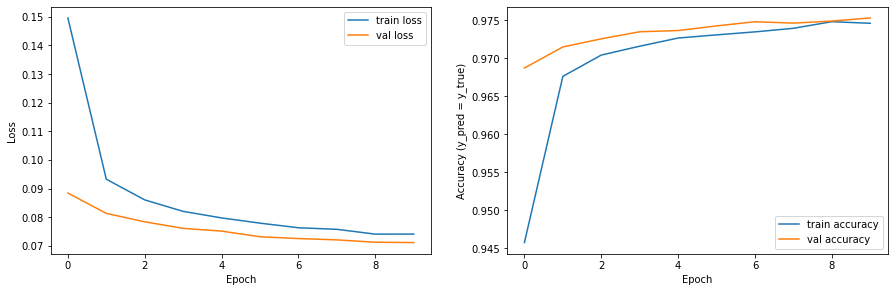

In [12]:
# plot loss vs epoch
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

# plot accuracy vs epoch
axes = plt.subplot(2, 2, 2)
axes.plot(history.history['accuracy'], label = 'train accuracy')
axes.plot(history.history['val_accuracy'], label = 'val accuracy')
axes.legend(loc = "lower right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Accuracy (y_pred = y_true)')

## Partition the test set into sig/bkg sets

In [13]:
# test set
test_sig_number = np.count_nonzero(Y_test)
test_bkg_number = np.count_nonzero(Y_test == 0)

X_test_sig = np.zeros((test_sig_number,X_test.shape[1]))
X_test_bkg = np.zeros((test_bkg_number,X_test.shape[1]))

j = 0
k = 0
for i in range(Y_test.shape[0]):
    if Y_test[i,0] == 1:
        X_test_sig[j,:] = X_test[i,:]
        j = j + 1
    else:
        X_test_bkg[k,:] = X_test[i,:]
        k = k + 1

# train+val set
train_val_sig_number = np.count_nonzero(Y_train_val)
train_val_bkg_number = np.count_nonzero(Y_train_val == 0)

X_train_val_sig = np.zeros((train_val_sig_number,X_train_val.shape[1]))
X_train_val_bkg = np.zeros((train_val_bkg_number,X_train_val.shape[1]))

j = 0
k = 0
for i in range(Y_train_val.shape[0]):
    if Y_train_val[i,0] == 1:
        X_train_val_sig[j,:] = X_train_val[i,:]
        j = j + 1
    else:
        X_train_val_bkg[k,:] = X_train_val[i,:]
        k = k + 1

## Test set performance plots

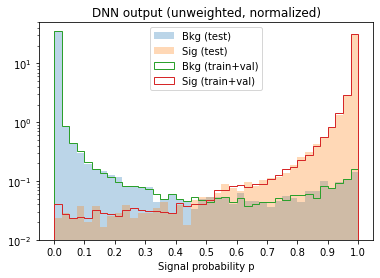

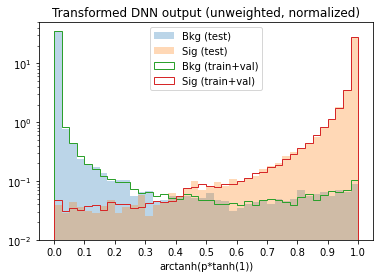

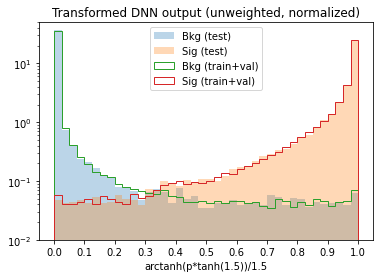

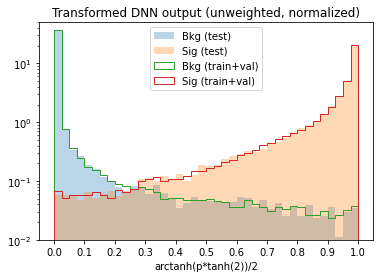

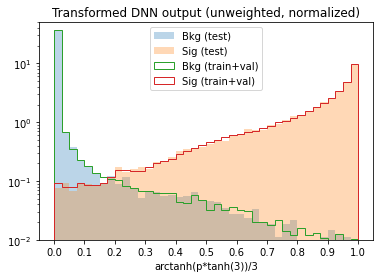

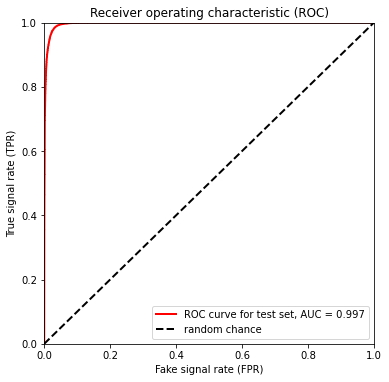

Test loss, test accuracy: [0.06627354152748485, 0.9762088656425476]


In [14]:
#pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 40, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 40, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(model.predict(X_test_sig), density = 1, range = (0.0, 1.0), bins = 40, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(model.predict(X_train_val_bkg), density = 1, range = (0.0, 1.0), bins = 40, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(model.predict(X_train_val_sig), density = 1, range = (0.0, 1.0), bins = 40, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('DNN output (unweighted, normalized)')
pyplot.xlabel('Signal probability p')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,5e1)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 40, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 40, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(1))')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,5e1)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(1.5))/1.5, density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(1.5))/1.5, density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(1.5))/1.5, density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(1.5))/1.5, density = 1, range = (0.0, 1), bins = 40, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(1.5))/1.5, density = 1, range = (0.0, 1), bins = 40, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(1.5))/1.5')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,5e1)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 40, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 40, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(2))/2')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,5e1)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 40, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 40, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(3))/3')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,5e1)
pyplot.show()

# Plot ROC
plt.figure(figsize = (13,13))
Y_predict = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
axes = plt.subplot(2, 2, 1)
axes.plot(fpr, tpr, lw = 2, color = 'red', label = 'ROC curve for test set, AUC = %.3f' % (roc_auc))
axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
axes.set_xlabel('Fake signal rate (FPR)')
axes.set_ylabel('True signal rate (TPR)')
axes.set_title('Receiver operating characteristic (ROC)')
axes.legend(loc = "lower right")
plt.show()

results = model.evaluate(X_test, Y_test, verbose = 0, batch_size = 256)
print("Test loss, test accuracy:", results)

## Save trained model

In [15]:
joblib.dump(scaler, 'trained_models_rerunBtag/em1b_scaler.gz')
model.save('trained_models_rerunBtag/em1b_model')

## Load saved model

In [ ]:
savedscaler = joblib.load('trained_models_rerunBtag/em1b_scaler.gz')
savedmodel = keras.models.load_model('trained_models_rerunBtag/em1b_model')
savedmodel.summary()

# Write model prediction to root files (NOW USE ANOTHER NOTEBOOK TO WRITE)

## Load all root files one by one

In [ ]:
from root_numpy import array2root

########### 2018
infolder18 = 'root_raw/em18_raw/'
outfolder18 = 'root_outputs/em18_outputs/'

inpaths18 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'W.root', 'W1.root', 'W2.root', 'W3.root', 'W4.root', 'WZ2L2Q.root', 'WZ3LNu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt12.root', 'ggH_bbtt20.root', 'ggH_bbtt30.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt50.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt12.root', 'vbf_bbtt20.root', 'vbf_bbtt30.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt50.root', 'vbf_bbtt60.root']

outpaths18 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'W.root', 'W1.root', 'W2.root', 'W3.root', 'W4.root', 'WZ2L2Q.root', 'WZ3LNu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'gghbbtt12.root', 'gghbbtt20.root', 'gghbbtt30.root', 'gghbbtt40.root'\
         , 'gghbbtt50.root', 'gghbbtt60.root', 'ttHnonbb.root'\
         , 'vbfbbtt12.root', 'vbfbbtt20.root', 'vbfbbtt30.root', 'vbfbbtt40.root'\
         , 'vbfbbtt50.root', 'vbfbbtt60.root']

for i in range(len(inpaths18)):
    inpaths18[i] = infolder18 + inpaths18[i]
    outpaths18[i] = outfolder18 + outpaths18[i]

allfiles18 = []
for i in range(len(inpaths18)):
    allfiles18.append(ROOT.RDataFrame('emu_tree', inpaths18[i]))


for i in range(len(allfiles18)):
    allfiles18[i] = allfiles18[i].Define('myele', myele)\
    .Define('mymu', mymu)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1mu', m_b1mu)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

########### 2017
infolder17 = 'root_raw/em17_raw/'
outfolder17 = 'root_outputs/em17_outputs/'

inpaths17 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'W.root', 'W1.root', 'W2.root', 'W3.root', 'W4.root', 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt12.root', 'ggH_bbtt20.root', 'ggH_bbtt30.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt50.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt12.root', 'vbf_bbtt20.root', 'vbf_bbtt30.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt50.root', 'vbf_bbtt60.root']

outpaths17 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'W.root', 'W1.root', 'W2.root', 'W3.root', 'W4.root', 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'gghbbtt12.root', 'gghbbtt20.root', 'gghbbtt30.root', 'gghbbtt40.root'\
         , 'gghbbtt50.root', 'gghbbtt60.root', 'ttHnonbb.root'\
         , 'vbfbbtt12.root', 'vbfbbtt20.root', 'vbfbbtt30.root', 'vbfbbtt40.root'\
         , 'vbfbbtt50.root', 'vbfbbtt60.root']

for i in range(len(inpaths17)):
    inpaths17[i] = infolder17 + inpaths17[i]
    outpaths17[i] = outfolder17 + outpaths17[i]

allfiles17 = []
for i in range(len(inpaths17)):
    allfiles17.append(ROOT.RDataFrame('emu_tree', inpaths17[i]))


for i in range(len(allfiles17)):
    allfiles17[i] = allfiles17[i].Define('myele', myele)\
    .Define('mymu', mymu)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1mu', m_b1mu)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

########### 2016
infolder16 = 'root_raw/em16_raw/'
outfolder16 = 'root_outputs/em16_outputs/'

inpaths16 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TT.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'W.root', 'W1.root', 'W2.root', 'W3.root', 'W4.root', 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt15.root', 'ggH_bbtt20.root', 'ggH_bbtt25.root', 'ggH_bbtt30.root', 'ggH_bbtt35.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt45.root', 'ggH_bbtt50.root', 'ggH_bbtt55.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt15.root', 'vbf_bbtt20.root', 'vbf_bbtt25.root', 'vbf_bbtt30.root', 'vbf_bbtt35.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt45.root', 'vbf_bbtt50.root', 'vbf_bbtt55.root', 'vbf_bbtt60.root']

outpaths16 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TT.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'W.root', 'W1.root', 'W2.root', 'W3.root', 'W4.root', 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'gghbbtt15.root', 'gghbbtt20.root', 'gghbbtt25.root', 'gghbbtt30.root', 'gghbbtt35.root', 'gghbbtt40.root'\
         , 'gghbbtt45.root', 'gghbbtt50.root', 'gghbbtt55.root', 'gghbbtt60.root', 'ttHnonbb.root'\
         , 'vbfbbtt15.root', 'vbfbbtt20.root', 'vbfbbtt25.root', 'vbfbbtt30.root', 'vbfbbtt35.root', 'vbfbbtt40.root'\
         , 'vbfbbtt45.root', 'vbfbbtt50.root', 'vbfbbtt55.root', 'vbfbbtt60.root']

for i in range(len(inpaths16)):
    inpaths16[i] = infolder16 + inpaths16[i]
    outpaths16[i] = outfolder16 + outpaths16[i]

allfiles16 = []
for i in range(len(inpaths16)):
    allfiles16.append(ROOT.RDataFrame('emu_tree', inpaths16[i]))


for i in range(len(allfiles16)):
    allfiles16[i] = allfiles16[i].Define('myele', myele)\
    .Define('mymu', mymu)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1mu', m_b1mu)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

## Data pre-processing

In [ ]:
######### 2018
for i in range(len(allfiles18)):
    allfiles18[i] = pd.DataFrame(allfiles18[i].AsNumpy(feature_list))
    allfiles18[i] = allfiles18[i].values
    allfiles18[i] = scaler.transform(allfiles18[i])
    print(inpaths18[i])

In [ ]:
######### 2017
for i in range(len(allfiles17)):
    allfiles17[i] = pd.DataFrame(allfiles17[i].AsNumpy(feature_list))
    allfiles17[i] = allfiles17[i].values
    allfiles17[i] = scaler.transform(allfiles17[i])
    print(inpaths17[i])

In [ ]:
######### 2016
for i in range(len(allfiles16)):
    allfiles16[i] = pd.DataFrame(allfiles16[i].AsNumpy(feature_list))
    allfiles16[i] = allfiles16[i].values
    allfiles16[i] = scaler.transform(allfiles16[i])
    print(inpaths16[i])

## Feed to NN and write outputs to root files

In [ ]:
######### 2018
for i in range(len(allfiles18)):
    y_pred = model.predict(allfiles18[i])
    y_pred = np.array(y_pred, dtype = [('dnn_1b', np.float32)])
    array2root(y_pred, filename = outpaths18[i], treename = 'emu_tree_dnn', mode = 'update')
    print(outpaths18[i])

In [ ]:
######### 2017
for i in range(len(allfiles17)):
    y_pred = model.predict(allfiles17[i])
    y_pred = np.array(y_pred, dtype = [('dnn_1b', np.float32)])
    array2root(y_pred, filename = outpaths17[i], treename = 'emu_tree_dnn', mode = 'update')
    print(outpaths17[i])

In [ ]:
######### 2016
for i in range(len(allfiles16)):
    y_pred = model.predict(allfiles16[i])
    y_pred = np.array(y_pred, dtype = [('dnn_1b', np.float32)])
    array2root(y_pred, filename = outpaths16[i], treename = 'emu_tree_dnn', mode = 'update')
    print(outpaths16[i])